'input', 'output_1', 'output_2', 'output_3', and 'output_4' folders created (if they didn't exist).


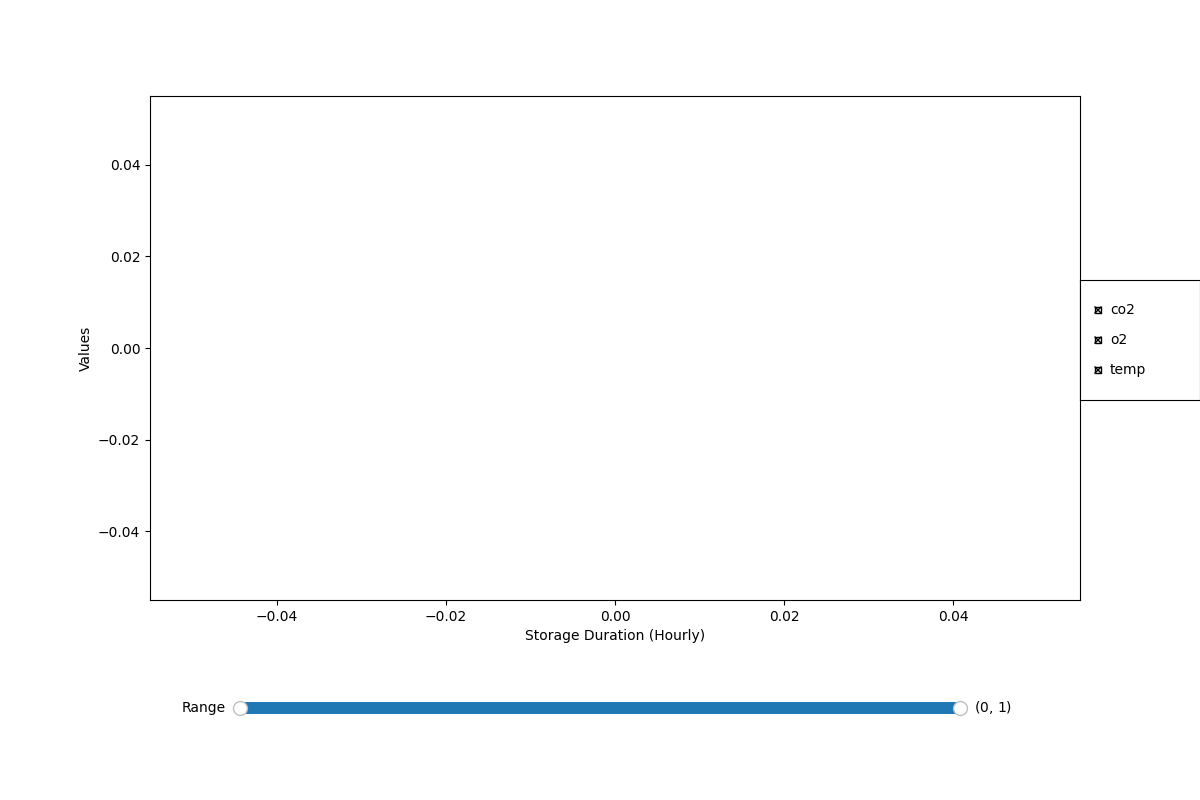

File 'ml.csv' loaded successfully.
All labeled data saved to output_1/1.csv
Screenshot saved for sensor 1 to output_3\sensor_1.png
XML data exported to output_2\sensor_1.xml
Remaining data saved to input\ml_remaining.csv


No such comm: 44cc542947564eed8672dbbd7dfac49b
No such comm: 44cc542947564eed8672dbbd7dfac49b
No such comm: 44cc542947564eed8672dbbd7dfac49b
No such comm: 44cc542947564eed8672dbbd7dfac49b


In [24]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import display
import ipywidgets as widgets
from matplotlib.widgets import RangeSlider, CheckButtons
from matplotlib.patches import Rectangle
import json
from PIL import Image
import matplotlib.dates as mdates
from io import BytesIO
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import random

# Global variables
subsetdf = pd.DataFrame()
sensor_id = None
lines = []
selected_folder_path = None
interval_size = 24
rectangles = []
selected_rectangles = []

global_screenshot_counter = 1  # Initialize a global screenshot counter

LABELS_FILE = 'labels.json'

def create_directories():
    """Create 'input' and necessary 'output' directories if they don't exist."""
    for folder in ['input', 'output_1', 'output_2', 'output_3', 'output_4']:
        if not os.path.exists(folder):
            os.makedirs(folder)
    print("'input', 'output_1', 'output_2', 'output_3', and 'output_4' folders created (if they didn't exist).")

create_directories()

def save_labels_to_file():
    with open(LABELS_FILE, 'w') as file:
        json.dump(label_list, file)

def load_labels_from_file():
    try:
        with open(LABELS_FILE, 'r') as file:
            label_list = json.load(file)
            return label_list
    except FileNotFoundError:
        # Default labels if no file is found
        label_list = ["Normal", "CO2 Problem", "O2 Problem", "Low CO2", "Low O2", "High CO2", "High O2", "Condensation (CO2)", "Condensation (O2)", "Lid Open"]
        return label_list

label_list = load_labels_from_file()

# Generate unique colors for each label
label_colors = {label: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for label in label_list}

class LabelManager:
    def __init__(self):
        self.current_labels = []

    def add_label(self, labels, xmin, xmax):
        # Find existing label for the same range
        existing_label = next((l for l in self.current_labels if l['xmin'] == xmin and l['xmax'] == xmax), None)
        if existing_label:
            existing_label['label'] = list(set(existing_label['label'] + labels))
        else:
            self.current_labels.append({
                'label': labels,
                'xmin': xmin,
                'xmax': xmax
            })

    def get_labels(self):
        return self.current_labels
    
    def clear_labels(self):
        """Clear all stored labels."""
        self.current_labels = []

    def merge_labels(self):
        """Merge labels with the same ranges."""
        if not self.current_labels:
            return []

        merged = [self.current_labels[0]]
        for label in self.current_labels[1:]:
            last_label = merged[-1]
            if label['label'] == last_label['label'] and label['xmin'] == last_label['xmax']:
                last_label['xmax'] = label['xmax']
            else:
                merged.append(label)
        self.current_labels = merged
        return self.current_labels



label_manager = LabelManager()

def update(val):
    """Update the plot based on the range slider values and update the x-axis label with Start and End dates."""
    if not subsetdf.empty:
        x_min, x_max = int(val[0]), int(val[1])
        x_min, x_max = max(0, x_min), min(len(subsetdf) - 1, x_max)

        x_margin = max((x_max - x_min) * 0.05, 1)
        ax.set_xlim(x_min - x_margin, x_max + x_margin)

        y_min = subsetdf.loc[x_min:x_max, ['co2', 'o2', 'temp']].min().min()
        y_max = subsetdf.loc[x_min:x_max, ['co2', 'o2', 'temp']].max().max()

        y_margin = (y_max - y_min) * 0.05
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        # Update x-axis label with Start and End dates
        start_date = subsetdf.loc[x_min, 'Date'].strftime('%Y-%m-%d %H:%M')
        end_date = subsetdf.loc[x_max, 'Date'].strftime('%Y-%m-%d %H:%M')
        ax.set_xlabel(f'Storage Duration (Hourly) - Start: {start_date}, End: {end_date}')

        plt.draw()

def all_rectangles_labeled():
    """Check if all rectangles in the plot are labeled."""
    global subsetdf, rectangles
    if 'label' not in subsetdf.columns:
        return False
    labeled_indices = set(subsetdf[subsetdf['label'] != ''].index)
    all_indices = set(range(len(subsetdf)))
    return labeled_indices == all_indices

def save_all_data(_):
    """Save all labeled data to a CSV file, create XML and PNG files, and clean up processed data."""
    global subsetdf, sensor_id, df
    
    if all_rectangles_labeled():
        if not subsetdf.empty:
            # Ensure Sensor ID is stored as an integer, not as a float
            subsetdf['Sensor ID'] = subsetdf['Sensor ID'].astype(int)
            
            # Add the 'fruit' column to the subsetdf DataFrame
            fruit_type = df[df['Sensor ID'] == int(sensor_id)]['fruit'].iloc[0] if 'fruit' in df.columns else 'Unknown'
            subsetdf['fruit'] = fruit_type
            
            # Reorder and rename the columns to match the desired format
            subsetdf = subsetdf[['Sensor ID', 'Date', 'o2', 'co2', 'temp', 'label', 'fruit']]
            
            # Save the labeled data to a CSV file in the specified format
            output_file = f"output_1/{sensor_id}.csv"
            subsetdf.to_csv(output_file, index=False)
            print(f"All labeled data saved to {output_file}")

            label_manager.merge_labels()
            merged_labels = label_manager.get_labels()

            full_df = df[df['Sensor ID'] == int(sensor_id)].copy()
            bounding_boxes, original_width, original_height = create_and_save_screenshot(
                full_df, subsetdf, sensor_id, merged_labels, save_to_folder='output_3'
            )
            
            export_to_xml(sensor_id, bounding_boxes, original_width, original_height, save_to_folder='output_2')
            
            remaining_df = df[df['Sensor ID'] != int(sensor_id)]
            df = remaining_df.copy()
            
            remaining_file_path = os.path.join('input', 'ml_remaining.csv')
            remaining_df.to_csv(remaining_file_path, index=False)
            print(f"Remaining data saved to {remaining_file_path}")
            
            all_sensor_ids = df['Sensor ID'].unique()
            labeled_sensor_ids = [int(f.split('.')[0]) for f in os.listdir('output_1') if f.endswith('.csv')]
            
            if set(all_sensor_ids) == set(labeled_sensor_ids):
                input_file = file_dropdown.value
                os.remove(os.path.join('input', input_file))
                print(f"All sensor IDs have been labeled. Deleted the main CSV file: {input_file}")



def create_and_save_screenshot(full_df, subsetdf, sensor_id, labels, use_sensor_name=False, save_to_folder='output_3'):
    global global_screenshot_counter
    try:
        # Verilerin tamamını kapsayacak şekilde figür boyutunu ayarlıyoruz
        fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

        full_dates = mdates.date2num(pd.to_datetime(full_df['Date']))
        subset_dates = mdates.date2num(pd.to_datetime(subsetdf['Date']))

        ax.plot(full_dates, full_df['co2'], marker='o', color='lightblue', alpha=0.3, label='CO2 Full')
        ax.plot(full_dates, full_df['o2'], marker='o', color='lightcoral', alpha=0.3, label='O2 Full')
        ax.plot(full_dates, full_df['temp'], marker='o', color='lightgreen', alpha=0.3, label='Temp Full')

        ax.plot(subset_dates, subsetdf['co2'], marker='o', color='blue', label='CO2 Subset')
        ax.plot(subset_dates, subsetdf['o2'], marker='o', color='orange', label='O2 Subset')
        ax.plot(subset_dates, subsetdf['temp'], marker='o', color='green', label='Temp Subset')

        ax.set_xlim(full_dates.min(), full_dates.max())

        # Eksen çizgilerini, etiketleri ve eksenleri kaldırıyoruz
        ax.axis('off')

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.legend().set_visible(False)

        # Kenarlarda boşluk kalmaması için pad_inches=0 ve bbox_inches='tight' ayarlarını kullanıyoruz
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        img = Image.open(buf)

        img_width, img_height = img.size

        bounding_boxes = []
        for label_info in labels:
            highlight_start = subset_dates[min(label_info['xmin'], len(subset_dates)-1)]
            highlight_end = subset_dates[min(label_info['xmax'], len(subset_dates)-1)]
            
            # Piksel koordinatlarını hesaplıyoruz
            left = (highlight_start - full_dates.min()) / (full_dates.max() - full_dates.min()) * img_width
            right = (highlight_end - full_dates.min()) / (full_dates.max() - full_dates.min()) * img_width
            top = 0
            bottom = img_height

            for label in label_info['label']:
                bounding_boxes.append({
                    'label': label,
                    'xmin': int(left),
                    'ymin': int(top),
                    'xmax': int(right),
                    'ymax': int(bottom)
                })

        screenshot_filename = f"sensor_{sensor_id}.png"
        screenshot_path = os.path.join(save_to_folder, screenshot_filename)
        img.save(screenshot_path)

        print(f"Screenshot saved for sensor {sensor_id} to {screenshot_path}")

        if not use_sensor_name:
            global_screenshot_counter += 1

    except Exception as e:
        print(f"Error saving screenshot for sensor {sensor_id}: {str(e)}")
        bounding_boxes = []
        img_width = 0
        img_height = 0

    finally:
        plt.close(fig)
        
    return bounding_boxes, img_width, img_height



def merge_labels(labels):
    if not labels:
        return []

    merged = [labels[0]]
    for label in labels[1:]:
        last_label = merged[-1]
        if label['label'] == last_label['label'] and label['xmin'] == last_label['xmax']:
            last_label['xmax'] = label['xmax']
        else:
            merged.append(label)
    return merged

def export_to_xml(sensor_id, bounding_boxes, img_width, img_height, save_to_folder='output_2'):
    xml_filename = os.path.join(save_to_folder, f"sensor_{sensor_id}.xml")
    
    root = ET.Element("annotation")
    
    ET.SubElement(root, "filename").text = f"sensor_{sensor_id}.png"
    ET.SubElement(root, "path").text = os.path.abspath(os.path.join('output_3', f"sensor_{sensor_id}.png"))
    
    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "Unknown"
    
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(int(img_width))
    ET.SubElement(size, "height").text = str(int(img_height))
    ET.SubElement(size, "depth").text = "3"
    
    ET.SubElement(root, "segmented").text = "0"
    
    merged_boxes = merge_labels(bounding_boxes)
    for box in merged_boxes:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = box["label"]
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = "0"
        ET.SubElement(obj, "difficult").text = "0"
        
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(int(box["xmin"]))
        ET.SubElement(bndbox, "ymin").text = str(int(box["ymin"]))
        ET.SubElement(bndbox, "xmax").text = str(int(box["xmax"]))
        ET.SubElement(bndbox, "ymax").text = str(int(box["ymax"]))
    
    xml_str = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
    with open(xml_filename, "w") as f:
        f.write(xml_str)
    
    print(f"XML data exported to {xml_filename}")

def on_submit(_):
    """Handle the submit button click to label the selected rectangles."""
    global selected_rectangles, save_all_button, sensor_id
    if selected_rectangles:
        selected_labels = [cb.description for cb in label_checkboxes.children if cb.value]
        for rect in selected_rectangles:
            min_index, max_index = int(rect.get_x()), int(rect.get_x() + rect.get_width())
            if subsetdf.loc[min_index:max_index, "label"].apply(lambda x: x == '').all():
                subsetdf.loc[min_index:max_index, "label"] = ','.join(selected_labels)
            else:
                subsetdf.loc[min_index:max_index, "label"] = subsetdf.loc[min_index:max_index, "label"].apply(
                    lambda x: ','.join(filter(None, set(x.split(',') + selected_labels))))
            rect.set_color(label_colors[selected_labels[0]])
        plt.draw()

        for rect in selected_rectangles:
            min_index, max_index = int(rect.get_x()), int(rect.get_x() + rect.get_width())
            label_manager.add_label(selected_labels, min_index, max_index)

        if all_rectangles_labeled():
            save_all_button.disabled = False
        
        selected_rectangles = []
        update_selected_labels_text()
    else:
        print("Select one or more rectangles first.")

def add_new_label(_):
    """Add a new label to the dropdown options."""
    new_label = new_label_text.value.strip()
    if new_label and new_label not in [cb.description for cb in label_checkboxes.children]:
        new_checkbox = widgets.Checkbox(value=False, description=new_label)
        label_checkboxes.children += (new_checkbox,)
        label_colors[new_label] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        new_label_text.value = ''
        print(f"New label '{new_label}' added.")
    else:
        print("Invalid or duplicate label.")

def delete_label(_):
    """Delete the selected label from the new label text."""
    label_to_delete = new_label_text.value.strip()
    checkboxes = list(label_checkboxes.children)
    for cb in checkboxes:
        if cb.description == label_to_delete:
            checkboxes.remove(cb)
            label_checkboxes.children = tuple(checkboxes)
            new_label_text.value = ''
            print(f"Label '{label_to_delete}' deleted.")
            return
    print("Selected label not found.")

def update_button_click(_):
    """Handle the update button click to change the sensor ID."""
    global sensor_id
    selected_sensor_id = sensor_id_dropdown.value
    update_sensor_id(selected_sensor_id)
    plt.draw()

def update_sensor_id(change):
    """Update the plot and data for the selected sensor ID, including the updated x-axis label."""
    global sensor_id, subsetdf, slider, lines, ax, rectangles, selected_rectangles, interval_size

    sensor_id = change

    if sensor_id is None or df.empty:
        return

    desired_df = df[df['Sensor ID'] == int(sensor_id)]
    if desired_df.empty:
        print(f"No data found for Sensor ID: {sensor_id}")
        return

    desired_df = desired_df.sort_values(by='Date')
    desired_df['Date'] = pd.to_datetime(desired_df['Date'])
    desired_df.set_index('Date', inplace=True)
    subsetdf = desired_df.resample('1h').mean(numeric_only=True)
    subsetdf = subsetdf.ffill()
    subsetdf.reset_index(inplace=True)
    subsetdf['label'] = ''

    subsetdf = subsetdf.sort_values(by='Date').reset_index(drop=True)

    for line, col in zip(lines, ['co2', 'o2', 'temp']):
        line.set_xdata(subsetdf.index)
        line.set_ydata(subsetdf[col])

    # Fruit türünü elde et
    fruit_type = df[df['Sensor ID'] == int(sensor_id)]['fruit'].iloc[0] if 'fruit' in df.columns else 'Unknown'

    # Başlığı dosya ismiyle birlikte güncelleyin
    loaded_file_name = file_dropdown.value
    ax.set_title(f'{sensor_id} - CO2, O2, and Temperature Over Time (Fruit Type: {fruit_type}) ({loaded_file_name} loaded)')

    slider.valmin, slider.valmax = 0, len(subsetdf) - 1
    slider.set_val((0, len(subsetdf) - 1))
    slider.ax.set_xlim(slider.valmin, slider.valmax)

    for rect in rectangles:
        rect.remove()
    rectangles.clear()
    save_all_button.disabled = True

    for i in range(0, len(subsetdf), interval_size):
        rect = Rectangle((i, ax.get_ylim()[0]), interval_size, ax.get_ylim()[1] - ax.get_ylim()[0], color='gray', alpha=0.25)
        rect.set_picker(True)
        ax.add_patch(rect)
        rectangles.append(rect)

    selected_rectangles = []

    update_legend()
    update(slider.val)


def on_pick(event):
    """Handle the picking event to select/deselect rectangles and show labels, only on left-click."""
    global selected_rectangles

    # Check if the event is related to a left mouse button click
    if isinstance(event.artist, Rectangle) and event.mouseevent.button == 1:
        rect = event.artist
        if rect in selected_rectangles:
            rect.set_edgecolor('black')
            rect.set_linewidth(1)
            selected_rectangles.remove(rect)
        else:
            rect.set_edgecolor('red')
            rect.set_linewidth(2)
            selected_rectangles.append(rect)
        plt.draw()

        update_selected_labels_text()
        update_labeled_region_text(rect)

def update_selected_labels_text():
    """Update the text displaying the selected labels."""
    selected_labels = [cb.description for cb in label_checkboxes.children if cb.value]
    if selected_labels:
        selected_labels_text.value = f"Selected Labels: {', '.join(selected_labels)}"
    else:
        selected_labels_text.value = "Selected Labels: None"

def update_labeled_region_text(rect):
    """Update the text displaying the labels for the selected region."""
    min_index, max_index = int(rect.get_x()), int(rect.get_x() + rect.get_width())
    labels_in_region = subsetdf.loc[min_index:max_index, 'label'].unique()
    if len(labels_in_region) > 0:
        labeled_region_text.value = f"Labeled Region: {', '.join(labels_in_region)}"
    else:
        labeled_region_text.value = "Labeled Region: None"


def toggle_line_visibility(label):
    """Toggle the visibility of a line in the plot."""
    index = choices.index(label)
    lines[index].set_visible(not lines[index].get_visible())
    update_legend()
    plt.draw()

def update_legend():
    """Update the legend based on visible lines."""
    visible_lines = [line for line in lines if line.get_visible()]
    if visible_lines:
        ax.legend(handles=visible_lines)
    else:
        ax.legend().set_visible(False)

def handle_file_selection(_):
    """Handle the file selection and load the selected CSV file."""
    global df, sensor_id_dropdown, sensor_id

    selected_file = file_dropdown.value
    if not selected_file:
        print("Please select a file first.")
        return

    file_path = os.path.join('input', selected_file)

    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])

        if 'Sensor ID' in df.columns:
            sensor_id_options = df['Sensor ID'].unique()
            sensor_id_dropdown.options = sensor_id_options
            sensor_id = sensor_id_options[0] if len(sensor_id_options) > 0 else None
            if sensor_id is not None:
                update_sensor_id(sensor_id)
                print(f"File '{selected_file}' loaded successfully.")
                submit_button.disabled = False
            else:
                print("No Sensor IDs found in the selected file.")
        else:
            print("No 'Sensor ID' column found in the selected file.")
    except Exception as e:
        print(f"Error reading the file: {str(e)}")


def update_interval_size(change):
    """Update the interval size and redraw rectangles."""
    global interval_size
    interval_size = change.new
    update_sensor_id(sensor_id)

input_folder = 'input'
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

file_dropdown = widgets.Dropdown(
    options=csv_files,
    description='Select File:',
    disabled=False,
)
file_dropdown.observe(handle_file_selection, names='value')
confirm_file_button = widgets.Button(description="Load Selected File", layout=widgets.Layout(width='120px', height='30px'), tooltip="Load the selected CSV file")
confirm_file_button.on_click(handle_file_selection)

choices = ('co2', 'o2', 'temp')
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(False)

l0, = ax.plot([], [], label='CO2', marker='o')
l1, = ax.plot([], [], label='O2', marker='o')
l2, = ax.plot([], [], label='Temperature', marker='o')
lines = (l0, l1, l2)

ax.set_xlabel('Storage Duration (Hourly)')
ax.set_ylabel('Values')
ax.legend().set_visible(False)

slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
plt.subplots_adjust(bottom=0.25)
slider = RangeSlider(slider_ax, label='Range', valmin=0, valmax=1, valinit=(0, 1))
slider.on_changed(update)

checkbox_ax = plt.axes([0.9, 0.5, 0.1, 0.15])
checkbox = CheckButtons(checkbox_ax, choices, [True] * len(choices))
checkbox.on_clicked(toggle_line_visibility)

fig.canvas.mpl_connect('pick_event', on_pick)

# Seçilen etiketleri gösterecek bir Text widget'ı oluşturuyoruz
selected_labels_text = widgets.Text(value='Selected Labels: None', description='Selected:', disabled=True, layout=widgets.Layout(width='60%'))

# Label edilmiş bölgeyi gösterecek bir Text widget'ı oluşturuyoruz
labeled_region_text = widgets.Text(value='Labeled Region: None', description='Region:', disabled=True, layout=widgets.Layout(width='60%'))

# Checkbox seçeneklerini iki satır halinde düzenlemek için GridBox kullanıyoruz
rows = 1  # Tek satır olarak ayarlandı
columns = (len(label_list) + 1) // rows

label_checkboxes = widgets.GridBox(
    children=[widgets.Checkbox(
        value=False, 
        description=label, 
        layout=widgets.Layout(width='auto', height='auto', padding='0px', margin='0px'),
        style={'description_width': 'initial'},
    ) for label in label_list],
    layout=widgets.Layout(
        grid_template_columns=f'repeat({columns}, 1fr)',
        grid_gap="2px",  # Boşlukları en aza indirdik
        width='100%'
    )
)

def update_selected_labels_text():
    """Seçilen etiketleri gösteren metin alanını güncelle."""
    selected_labels = [cb.description for cb in label_checkboxes.children if cb.value]
    if selected_labels:
        selected_labels_text.value = f"Selected Labels: {', '.join(selected_labels)}"
    else:
        selected_labels_text.value = "Selected Labels: None"

# Etiket seçimi değiştiğinde çağrılacak işlevi ekliyoruz
def on_label_change(change):
    update_selected_labels_text()

for checkbox in label_checkboxes.children:
    checkbox.observe(on_label_change, 'value')

sensor_id_dropdown = widgets.Dropdown()

select_sensor_label_button = widgets.Button(description="Select Sensor ID", tooltip="Update the plot for the selected sensor ID")
select_sensor_label_button.on_click(update_button_click)

submit_button = widgets.Button(description="Submit Labels", tooltip="Apply selected labels to highlighted data intervals")
submit_button.on_click(on_submit)

new_label_text = widgets.Text(placeholder="Enter a label")
add_label_button = widgets.Button(description="Add Label", tooltip="Add a new label to the list")
add_label_button.on_click(add_new_label)

delete_label_button = widgets.Button(description="Delete Label", tooltip="Delete the label specified in the text box")
delete_label_button.on_click(delete_label)

save_all_button = widgets.Button(description="Save All Data", tooltip="Save labeled data and associated files")
save_all_button.on_click(save_all_data)
submit_button.disabled = True

interval_size_dropdown = widgets.Dropdown(
    options=[24, 48],
    value=interval_size,
    description='Window Size:',
    tooltip="Adjust the time window size for labeling",
)
interval_size_dropdown.observe(update_interval_size, names='value')

def clear_selected_regions(_):
    """Clear all selected regions and reset labels."""
    global subsetdf, rectangles, selected_rectangles
    
    subsetdf['label'] = ''
    label_manager.clear_labels()
    
    for rect in rectangles:
        rect.set_color('gray')
        rect.set_alpha(0.25)
    
    selected_rectangles = []
    save_all_button.disabled = True
    
    plt.draw()
    print("All selected regions have been cleared.")
    update_selected_labels_text()

clear_regions_button = widgets.Button(description="Clear Selected Regions", tooltip="Clear all selected regions and reset their labels")
clear_regions_button.on_click(clear_selected_regions)

def take_screenshot(_):
    """Take a screenshot of the current graph."""
    if not subsetdf.empty:
        full_df = df[df['Sensor ID'] == int(sensor_id)].copy()
        create_and_save_screenshot(full_df, subsetdf, sensor_id, label_manager.current_labels, use_sensor_name=True, save_to_folder='output_4')
    else:
        print("No data to capture.")

screenshot_button = widgets.Button(description="Take Screenshot", tooltip="Capture and save a screenshot of the current graph")
screenshot_button.on_click(take_screenshot)

# Clear selected parts button
def clear_selected_parts(_):
    global selected_rectangles
    for rect in selected_rectangles:
        rect.set_edgecolor('black')
        rect.set_linewidth(1)
    selected_rectangles = []
    plt.draw()
    update_selected_labels_text()
    print("Selected parts have been cleared.")

clear_selected_parts_button = widgets.Button(description="Clear Selected Parts", tooltip="Clear selection from highlighted parts")
clear_selected_parts_button.on_click(clear_selected_parts)

main_container = widgets.VBox([])

file_selection = widgets.HBox([file_dropdown, confirm_file_button])
sensor_selection = widgets.HBox([sensor_id_dropdown, select_sensor_label_button, interval_size_dropdown])
top_container = widgets.VBox([file_selection, sensor_selection])

label_controls = widgets.HBox([submit_button, save_all_button])
new_label_controls = widgets.HBox([new_label_text, add_label_button, delete_label_button])
labeling_container = widgets.VBox([label_controls, new_label_controls])

action_buttons = widgets.HBox([clear_regions_button, screenshot_button, clear_selected_parts_button])

# Etiketleri en alt kısma taşıyoruz
main_container.children = [top_container, labeling_container, action_buttons, selected_labels_text, labeled_region_text, label_checkboxes]

main_container.layout.width = '70%'
main_container.layout.margin = '10px'

display(main_container)

plt.show()